In [ ]:
from google.colab import drive
import zipfile
import os

MOUNT_DIR = '/content/drive'
DATA_DIR_SMALLER = '/content/drive/MyDrive/DatasetSmaller.zip'
EXTRACTED_DIR = '/content/dataFolder'

# Mount Google Drive
drive.mount(MOUNT_DIR, force_remount=False)

# Path to the zip file in your Google Drive
zip_file_path = DATA_DIR_SMALLER

# Directory to extract the contents
extracted_dir_path = EXTRACTED_DIR


def extract_data(extracted_dir_path):
  # Extract the zip file
  with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
      zip_ref.extractall(extracted_dir_path)

extract_data(extracted_dir_path)

Mounted at /content/drive


In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import os
from PIL import Image

class ChestDataset(Dataset):
    def __init__(self, **kwargs):
        self.path = kwargs.get('path')
        self.transform = kwargs.get('transform')
        self.data = datasets.ImageFolder(self.path, transform=self.transform)
        self.path_label_list = self.data.imgs

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        # Load image and label from the dataset based on the index
        image_path, label = self.path_label_list[index]

        try:
            image = Image.open(image_path).convert("RGB")
        except Exception as e:
            print(f"Error loading image: {image_path}, {e}")
            return None, None

        # Optionally apply transformations
        if self.transform:
            image = self.transform(image)

        return image, label

def get_dataset(root):
    # Define transformations for the images
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])

    # Load datasets for training, validation, and test with size (224, 224)
    dataset = ChestDataset(path=root, transform=transform)

    # Compute mean and std for normalization
    def compute_mean_and_std(dataset):
        mean_sum = np.zeros(3)
        std_sum = np.zeros(3)
        num_samples = len(dataset)

        for img, _ in dataset:
            img = np.array(img)
            # Compute mean along height and width axes
            img_mean = np.mean(img, axis=(1, 2))
            # Compute std along height and width axes
            img_std = np.std(img, axis=(1, 2))

            mean_sum += img_mean
            std_sum += img_std

        # Compute overall mean and std across all images
        mean = mean_sum / num_samples
        std = std_sum / num_samples

        return mean, std

    train_mean, train_std = compute_mean_and_std(dataset)

    # Apply normalization with computed mean and std
    transform = transforms.Compose([
        transform,
        transforms.Normalize(mean=train_mean, std=train_std)
    ])

    # Apply normalization to datasets
    dataset.transform = transform

    return dataset

In [ ]:
import os
import cv2
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, make_scorer, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc
import cv2
import numpy as np
from skimage.feature import hog
import matplotlib.pyplot as plt

# Prepare the dataset
data_foldername = 'dataFolder/folder'

dataset_path = os.path.join(os.getcwd(), data_foldername)
dataset = get_dataset(dataset_path)

# Extract HOG features from images
X = []
y = []
iter = 0
for img, label in dataset:
    iter += 1
    if iter % 100 == 0:
        print(iter)
    img_np = np.array(img.permute(1, 2, 0))
    img_gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
    hog_features = hog(img_gray, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=False)
    X.append(hog_features)
    y.append(label)
# Convert to numpy arrays

X = np.array(X)
y = np.array(y)

100
200
300
400
500
600
700
800
900
1000


k: 5
k: 25
k: 75
k: 125
k: 225
k: 451
k: 751
Best accuracy: 0.265 achieved with k = 25


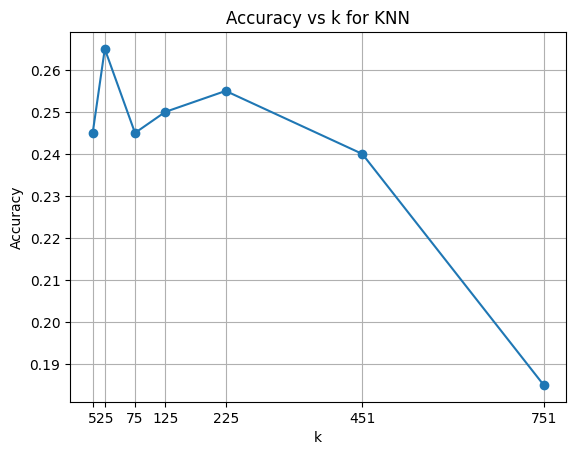

Accuracy: 0.2650
Macro Precision: 0.3025
Macro Recall: 0.2741
Macro F1 Score: 0.2426


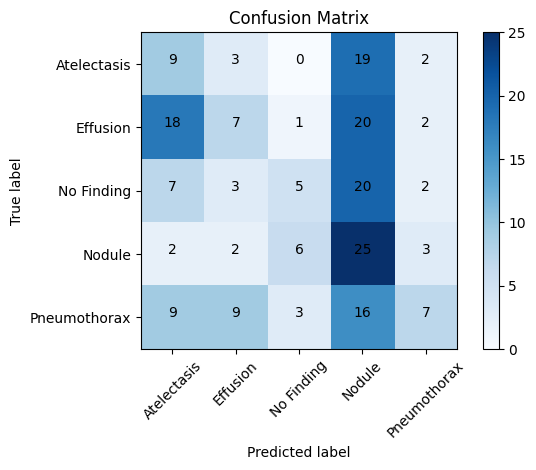

Test Accuracy: 0.265
Classification Report on Test Data:
               precision    recall  f1-score   support

           0       0.20      0.27      0.23        33
           1       0.29      0.15      0.19        48
           2       0.33      0.14      0.19        37
           3       0.25      0.66      0.36        38
           4       0.44      0.16      0.23        44

    accuracy                           0.27       200
   macro avg       0.30      0.27      0.24       200
weighted avg       0.31      0.27      0.24       200



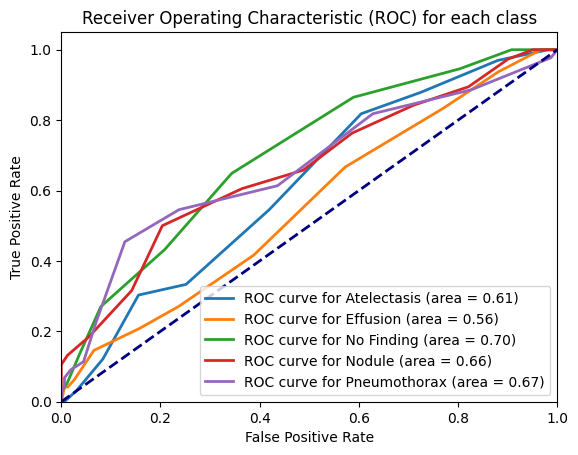

In [ ]:

import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define values of k
k_values = [5, 25, 75, 125, 225, 451, 751]

# Initialize lists to store accuracies
accuracies = []

best_accuracy = 0
best_k = None
best_model = None
for k in k_values:
    print(f"k: {k}")

    # Create an instance of KNeighborsClassifier and fit the model on the training data
    model = KNeighborsClassifier(n_neighbors=k)

    model.fit(X_train, y_train)

    # Make predictions on the testing data
    y_pred = model.predict(X_test)

    # Evaluate the model's accuracy
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

    # Check if the current accuracy is the best so far
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_k = k
        best_model = model

def plot_accuracy_vs_k(k_values, accuracies):
    # Plot accuracy vs k
    plt.plot(k_values, accuracies, marker='o')
    plt.xlabel('k')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs k for KNN')
    plt.xticks(k_values)
    plt.grid(True)
    plt.show()

print(f"Best accuracy: {best_accuracy} achieved with k = {best_k}")

def print_metrics_and_plot_confusion_matrix(best_model, y_test):
    # Make predictions on the testing data
    y_pred = best_model.predict(X_test)

    # Evaluate the model's accuracy
    acc = accuracy_score(y_test, y_pred)
    pre = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    metrics = {
        'accuracy': acc,
        'precision': pre,
        'recall': recall,
        'f1_score': f1
    }

    print("Accuracy: {:.4f}\nMacro Precision: {:.4f}\nMacro Recall: {:.4f}\nMacro F1 Score: {:.4f}".format(
        metrics['accuracy'], metrics['precision'], metrics['recall'], metrics['f1_score']))

    #plot confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(conf_matrix)
    report = classification_report(y_test, y_pred)

    print("Test Accuracy:", acc)
    print("Classification Report on Test Data:\n", report)

    #Convert y_test to binary format
    y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
    y_prob = best_model.predict_proba(X_test)

    #Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(len(np.unique(y_test))):
        fpr[i], tpr[i],_  = roc_curve(y_test_bin[:, i], y_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    #Plot ROC curves for each class
    plt.figure()
    lw = 2
    classes = ['Atelectasis', 'Effusion', 'No Finding', 'Nodule', 'Pneumothorax']
    for i in range(len(np.unique(y_test))):
        plt.plot(fpr[i], tpr[i], lw=lw, label='ROC curve for {} (area = {:.2f})'.format(classes[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) for each class')
    plt.legend(loc="lower right")
    plt.show()

def plot_confusion_matrix(conf_matrix):
    plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')
    plt.title("Confusion Matrix")
    plt.colorbar()
    classes = ['Atelectasis', 'Effusion', 'No Finding', 'Nodule', 'Pneumothorax']
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    for i in range(len(classes)):
        for j in range(len(classes)):
            plt.text(j, i, format(conf_matrix[i, j], 'd'), horizontalalignment="center", color="black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

plot_accuracy_vs_k(k_values, accuracies)
print_metrics_and_plot_confusion_matrix(best_model, y_test)